In [316]:
import sys
import os
import typing as tp
import tqdm

sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))
import itertools

from dataclasses import dataclass
import numpy as np
import torch 
from torch import nn
import math

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager, particles
from visualization import levels_plot, transitions_plot
from population import time_population, tr_utils, transform
import population

import machine_learning as ml

import pathlib
from importlib import reload

from spectra_manager import TruncatedSpectraCreatorTimeResolved, PostSpectraProcessing,TimeResolvedIntensitiesCalculator, ParamSpec
from spectral_integration import SpectraIntegratorEasySpinLikeTimeResolved, BaseSpectraIntegrator
from reader import read_bruker_data
from spectra_manager import BaseSpectraCreator
import spectral_integration
import optimization
import particles
import random
import pickle

import spectra_processing

reload(population)
reload(optimization.fitter)
reload(optimization.objectives)
reload(time_population)
reload(levels_plot)
reload(transitions_plot)
reload(tr_utils)
reload(spectral_integration)
reload(spectra_manager)
reload(spin_system)
reload(res_field_algorithm)
reload(optimization)

<module 'optimization' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\optimization\\__init__.py'>

In [317]:
reload(utils)

<module 'utils' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\utils.py'>

In [318]:
import safetensors.torch
import safetensors

import traceback
import datetime

In [324]:
from particles import Nucleus
from torch.distributions import Uniform
import torch

reload(mesher)
reload(ml.transforms)
reload(mesher.delanay_neigbour)
reload(ml.spectra_generation)
reload(ml.data_generation)
reload(ml.data_loading)
reload(ml)

<module 'machine_learning' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\machine_learning\\__init__.py'>

In [325]:
ham_strain=torch.tensor([[1e7], [1e7]])

In [330]:
intercation = spin_system.Interaction(components=torch.tensor([[2.0, 2.3, 2.0], [2.0, 2.3, 2.0]]))
DE_interaction = spin_system.Interaction(components=torch.tensor([[-1e12, 1e12, -1e4], [-1e12, 1e12, -1e4]]))

base_system = spin_system.SpinSystem((1.0, ), g_tensors=[intercation], electron_electron=[(0,0,DE_interaction)])

sample = spin_system.MultiOrientedSample(spin_system=base_system, ham_strain=torch.tensor([[1e7, 1e7, 1e7], [1e7, 1e7, 1e7]]))
gen_creator = ml.GenerationCreator(freq=9e9, sample=sample)
fields = torch.tensor([[0.1, 0.5], [0.1, 0.5]])
spec, (min_pos_batch, max_pos_batch) = gen_creator(fields=fields, sample=sample)

steps = torch.linspace(0, 1, spec.shape[-1])
fields = steps * (max_pos_batch - min_pos_batch).unsqueeze(-1) + min_pos_batch.unsqueeze(-1)

In [331]:
min_pos_batch.shape

torch.Size([2, 1, 2])

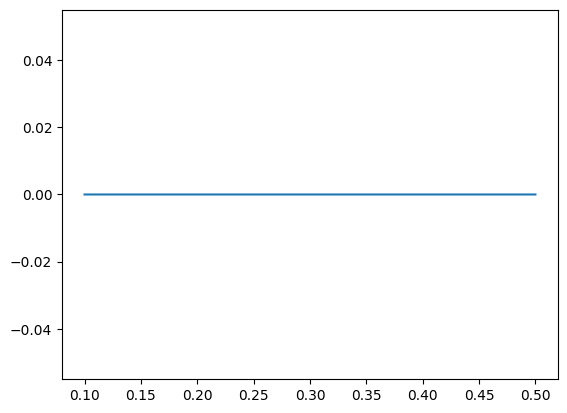

In [332]:
plt.plot(fields[0,0,0].numpy(), spec[0,0,0].numpy())

In [297]:
rng_generator = random.Random(42)

ion_spin_defaults = {"63Cu": [1/2], "65Cu": [1/2], "59Co": [3/2, 1/2], "55Mn": [3/2, 5/2, 2]}
generator = ml.RandomStructureGenerator(
    max_num_electrons=5,
    min_num_electrons=1,
    max_num_nuclei=2,
    min_num_nuclei=1,
    ion_spin_defaults=ion_spin_defaults,
    ion_spin_usage_prob=0.5,
    max_dim=100,
    rng_generator=rng_generator
)
structure = generator()
structure

SpinSystemStructure(num_electrons=1, num_nuclei=1, nuclei=['55Mn'], electron_nuclei=[(0, 0)], electron_electron=[], nuclei_nuclei=[], nuclei_spins=[2.5], electrons_spins=[1.5], bound_map={0: 0}, spin_system_dim=24)

In [298]:
g_angles_levels = ([
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, 2 * math.pi), (0.0, math.pi), (0.0, 2 * math.pi)],
        vary_shift = (math.pi / 20, math.pi / 20, math.pi / 20)
    ),
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, math.pi / 8), (0.0, math.pi / 8), (0.0, math.pi / 8)],
        vary_shift = (math.pi / 80, math.pi / 80, math.pi / 80)
    )
        ], (0.5, 0.5))
g_tensor_orientation_generator = ml.MultiDimensionalTensorGenerator(levels=g_angles_levels[0], output_dims=3, rng_generator=rng_generator, probabilities=g_angles_levels[1])


nuclei_angles_levels = ([
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, 2 * math.pi), (0.0, math.pi), (0.0, 2 * math.pi)],
        vary_shift = (math.pi / 20, math.pi / 20, math.pi / 20)
    ),
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, math.pi / 8), (0.0, math.pi / 8), (0.0, math.pi / 8)],
        vary_shift = (math.pi / 80, math.pi / 80, math.pi / 80)
    )
        ], (0.5, 0.5))
hyperfine_orientation_generator = ml.MultiDimensionalTensorGenerator(levels=nuclei_angles_levels[0], output_dims=3, rng_generator=rng_generator, probabilities=nuclei_angles_levels[1])


el_el_angles_levels = ([
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, 2 * math.pi), (0.0, math.pi), (0.0, 2 * math.pi)],
        vary_shift = (math.pi / 20, math.pi / 20, math.pi / 20)
    ),
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0, math.pi / 8), (0.0, math.pi / 8), (0.0, math.pi / 8)],
        vary_shift = (math.pi / 80, math.pi / 80, math.pi / 80)
    )
        ], (0.5, 0.5))
electron_electron_orientation_generator = ml.MultiDimensionalTensorGenerator(levels=el_el_angles_levels[0], output_dims=3, rng_generator=rng_generator, probabilities=el_el_angles_levels[1])

In [277]:
g_levels = ([
    ml.UncorrelatedLevel(
        initial_bounds=[(1.9, 2.4), (1.9, 2.4), (1.9, 2.4),],
        vary_shift = (0.02, 0.02, 0.02)
    )
        ], None
)

g_tensor_components_generator = ml.MultiDimensionalTensorGenerator(levels=g_levels[0], output_dims=3, rng_generator=rng_generator)

In [278]:
nuclei_levels = {"1H": ([
    ml.IsotropicLevel(
        isotropic_bounds=(-40.0 * 1e6, 40.0 * 1e6),
        isotropic_shift = 5.0 * 1e6,
        variation_bounds = (-2.0 * 1e6, 2.0 * 1e6),
        variation_shift = 0.5 * 1e6
    )
        ], None),
"2H": ([
    ml.IsotropicLevel(
        isotropic_bounds=(-40.0 * 1e6, 40.0 * 1e6),
        isotropic_shift = 5.0 * 1e6,
        variation_bounds = (-2.0 * 1e6, 2.0 * 1e6),
        variation_shift = 0.5 * 1e6
    )
        ], None),
"14N": ([
    ml.AxialLevel(
        parallel_bounds=(0.0 * 1e6, 110.0 * 1e6),
        parallel_shift = 4.0 * 1e6,
        perpendicular_bounds = (0.0 * 1e6, 25.0 * 1e6),
        perpendicular_shift = 4.0 * 1e6
    ),
    ml.AxialLevel(
        parallel_bounds=(-10.0, 0.0),
        parallel_shift = 4.0 * 1e6,
        perpendicular_bounds = (-10.0, 0.0),
        perpendicular_shift = 4.0 * 1e6
    )
        ],
    (0.7, 0.3)
),
"15N": ([
    ml.AxialLevel(
        parallel_bounds=(0.0 * 1e6, 110.0 * 1e6),
        parallel_shift = 6.0 * 1e6,
        perpendicular_bounds = (0.0 * 1e6, 25.0 * 1e6),
        perpendicular_shift = 6.0 * 1e6
    ),
    ml.AxialLevel(
        parallel_bounds=(-10.0, 0.0),
        parallel_shift = 4.0 * 1e6,
        perpendicular_bounds = (-10.0, 0.0),
        perpendicular_shift = 4.0 * 1e6
    )
        ],
    (0.7, 0.3)
),
"63Cu": ([
    ml.AxialLevel(
        parallel_bounds=(100.0 * 1e6, 600.0 * 1e6),
        parallel_shift = 10.0 * 1e6,
        perpendicular_bounds = (20.0 * 1e6, 120.0 * 1e6),
        perpendicular_shift = 10.0 * 1e6
    )], None),
"65Cu": ([
    ml.AxialLevel(
        parallel_bounds=(100.0 * 1e6, 600.0 * 1e6),
        parallel_shift = 10.0 * 1e6,
        perpendicular_bounds = (20.0 * 1e6, 120.0 * 1e6),
        perpendicular_shift = 10.0 * 1e6
    )], None),
"59Co": ([
    ml.UncorrelatedLevel(
        initial_bounds=[(0.0 * 1e6, 600.0 * 1e6), (0.0 * 1e6, 600.0 * 1e6), (0.0 * 1e6, 600.0 * 1e6)],
        vary_shift = (10 * 1e6, 10 * 1e6, 10 * 1e6)
    )
        ], None),
"55Mn": ([
    ml.UncorrelatedLevel(
        initial_bounds=[(-300.0 * 1e6, 300.0 * 1e6), (-300.0 * 1e6, 300.0 * 1e6), (-300.0 * 1e6, 300.0 * 1e6),],
        vary_shift = (10 * 1e6, 10 * 1e6, 10 * 1e6)
    )
        ], None),
"31P": ([
    ml.UncorrelatedLevel(
        initial_bounds=[(-300.0 * 1e6, 300.0 * 1e6), (-300.0 * 1e6, 300.0 * 1e6), (-300.0 * 1e6, 300.0 * 1e6)],
        vary_shift = (10 * 1e6, 10 * 1e6, 10 * 1e6)
    )
        ], None),
 
"19F": ([
    ml.UncorrelatedLevel(
        initial_bounds=[(-0.0 * 1.0e6, 100.0 * 1e6), (-0.0 * 1e6, 100.0 * 1e6), (-0.0 * 1e6, 100.0 * 1e6),],
        vary_shift = (10 * 1e6, 10 * 1e6, 10 * 1e6)
    )
        ], None),
}

hyperfine_coupling_generator = {key: ml.MultiDimensionalTensorGenerator(levels=value[0], output_dims=3, probabilities=value[1], rng_generator=rng_generator) for key, value in nuclei_levels.items()}

In [279]:
exchange_levels = [
    ml.IsotropicLevel(
        isotropic_bounds=(constants.unit_converter(-4.0, "cm-1_to_Hz"), constants.unit_converter(4.0, "cm-1_to_Hz")),
        isotropic_shift = constants.unit_converter(1.0, "cm-1_to_Hz"),
        
        variation_bounds = None,
        variation_shift = None,
    ),
    ml.IsotropicLevel(
        isotropic_bounds=(constants.unit_converter(-1.0, "cm-1_to_Hz"), constants.unit_converter(1.0, "cm-1_to_Hz")),
        isotropic_shift = constants.unit_converter(0.2, "cm-1_to_Hz"),
        
        variation_bounds = None,
        variation_shift = None,
    ),
]
exchange_coupling_generator = ml.MultiDimensionalTensorGenerator(levels=exchange_levels, output_dims=1, probabilities=(0.5, 0.5))


diplolar_levels = [
    ml.DELevel(
        D_bounds=(-250.0 * 1e6, 250.0 * 1e6),
        E_attitude_bounds = (0.0, 0.3),

        D_shift = 10.0,
        E_attitude_shift = 0.02,
    )
]
dipolar_coupling_generator = ml.MultiDimensionalTensorGenerator(levels=diplolar_levels, output_dims=2, probabilities=None, rng_generator=rng_generator)

In [280]:
zfs_levels = [
    ml.DELevel(
        D_bounds=(constants.unit_converter(-3.0, "cm-1_to_Hz"), constants.unit_converter(3.0, "cm-1_to_Hz")),
        E_attitude_bounds = (0.0, 0.3),

        D_shift = constants.unit_converter(1.0, "cm-1_to_Hz"),
        E_attitude_shift = 0.02,
    )
]
zero_field_splitting_generator = ml.MultiDimensionalTensorGenerator(levels=zfs_levels, output_dims=2, probabilities=None, rng_generator=rng_generator)

In [281]:
temperature_levels = [
    ml.IsotropicLevel(
        isotropic_bounds=(3.5, 300.0),
        isotropic_shift = 50.0,
        
        variation_bounds = None,
        variation_shift = None,
    ),
]
temperature_generator = ml.MultiDimensionalTensorGenerator(levels=temperature_levels, output_dims=1, probabilities=None, rng_generator=rng_generator)

In [282]:
constants.unit_converter(5.0e-2, "T_to_Hz_e")

699812245.8528454

In [283]:
hamiltonian_levels = [
    ml.IsotropicLevel(
        isotropic_bounds=(constants.unit_converter(5.0e-3, "T_to_Hz_e"), constants.unit_converter(5.0e-2, "T_to_Hz_e")),
        isotropic_shift = constants.unit_converter(5.0e-4, "T_to_Hz_e"),
        
        variation_bounds = (constants.unit_converter(1.0e-4, "T_to_Hz_e"), constants.unit_converter(1.0e-3, "T_to_Hz_e")),
        variation_shift = constants.unit_converter(0.5e-4, "T_to_Hz_e"),
    ),
]
hamiltonian_strain_generator = ml.MultiDimensionalTensorGenerator(levels=hamiltonian_levels, output_dims=3, probabilities=None, rng_generator=rng_generator)

In [284]:
freq_levels = [
    ml.IsotropicLevel(
        isotropic_bounds=(8.8 * 1e9, 10.0 * 1e9),
        isotropic_shift = 0.02 * 1e9,
        
        variation_bounds = None,
        variation_shift = None,
    ),
    ml.IsotropicLevel(
        isotropic_bounds=(25.0 * 1e9, 40.0 * 1e9),
        isotropic_shift = 0.02 * 1e9,
        
        variation_bounds = None,
        variation_shift = None,
    ),
]
freq_generator = ml.MultiDimensionalTensorGenerator(levels=freq_levels, output_dims=1, probabilities=None, rng_generator=rng_generator)

In [285]:
from IPython.display import clear_output
reload(ml.data_generation)
reload(ml.spectra_generation)
reload(ml)

<module 'machine_learning' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\machine_learning\\__init__.py'>

In [286]:
path = "D:\ITC\generation"

ion_spin_defaults = {"63Cu": [1/2], "65Cu": [1/2], "59Co": [3/2, 1/2], "55Mn": [3/2, 5/2, 2]}
struct_generator = ml.RandomStructureGenerator(
    max_num_electrons=2,
    min_num_electrons=2,
    max_num_nuclei=0,
    min_num_nuclei=0,
    ion_spin_defaults=ion_spin_defaults,
    ion_spin_usage_prob=0.0,
    max_dim=12,
    zfs_probability=1.0,
    rng_generator=rng_generator
)
structure = struct_generator()
dtype = torch.float64
mesh = mesher.DelaunayMeshNeighbour(initial_grid_frequency=3, interpolation_grid_frequency=3, dtype=dtype)

In [287]:
device = torch.device("cuda") if torch.torch.cuda.is_available() else torch.device("cpu")


data_generator = ml.DataFullGenerator(
    path=path,
    struct_generator=struct_generator,
    mesh=mesh,
    freq_generator=freq_generator,
    temperature_generator=temperature_generator,
    hamiltonian_strain_generator=hamiltonian_strain_generator,
    g_tensor_components_generator=g_tensor_components_generator,
    g_tensor_orientation_generator=g_tensor_orientation_generator,
    hyperfine_coupling_generator=hyperfine_coupling_generator,
    hyperfine_orientation_generator=hyperfine_orientation_generator,
    exchange_coupling_generator=exchange_coupling_generator,
    dipolar_coupling_generator=dipolar_coupling_generator,
    zero_field_splitting_generator=zero_field_splitting_generator,
    electron_electron_orientation_generator=electron_electron_orientation_generator,
    alarm_time = 60 * 5, # 5 minutes
    device=device,
    dtype=dtype
    
)

In [ ]:
data_generator.generate(1,5,5,2, dtype=dtype)

In [36]:
torch.cuda.empty_cache()

### DataLoading

In [99]:
import machine_learning as ml

In [122]:
reload(ml.data_loading)
reload(ml.transforms)
reload(ml)

<module 'machine_learning' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\machine_learning\\__init__.py'>

In [123]:
root_path = "D:\ITC\generation"
path_structure = "D:\ITC\generation\structure_0000"
path_sample = "D:\ITC\generation\structure_0000\mean_0000\sample_0000"

In [124]:
structure, generator_summary = ml.FileParser().open_structure(path_structure)

In [125]:
out = ml.FileParser().to_graph_data(structure, generator_summary, path_sample, None, None)

In [126]:
dataset = ml.EPRDataset(
    root_dir = root_path
)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([5, 3, 4, 1, 1])
torch.Size([5, 3, 4, 1, 3])
123
torch.Size([2, 3, 4, 1])
torch.Size([2, 3, 4, 1, 1])
torch.Size([1, 3, 4, 1, 3])
123


RuntimeError: Sizes of tensors must match except in dimension 4. Expected size 1 but got size 2 for tensor number 3 in the list.

In [58]:
out["types"][..., 0, 0, 0]

tensor([0, 0, 2, 2, 2])

In [80]:
[0 for _ in range(1, out["types"].dim())]

[0, 0, 0]

In [69]:
spins_feature = -torch.ones_like(out["types"], dtype=torch.float32)

In [87]:
result = out["types"][(slice(None),) + (0,) * (out["types"].ndim - 1)]

mask_particles = (result != 2)

In [88]:
mask_particles.shape

torch.Size([5])

In [72]:
spins_feature[mask_particles, ...] = out["spins"]

In [74]:
spins_feature[:, 0, 0, 0]

tensor([ 1.5000,  1.0000, -1.0000, -1.0000, -1.0000])

In [40]:
reload(ml.transforms)
reload(ml)

<module 'machine_learning' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\machine_learning\\__init__.py'>

In [41]:
import pathlib